In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
from keras import Input,Model,backend
from keras.layers import Embedding,LSTM,Dense,Multiply,TimeDistributed
from keras.applications import DenseNet121
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import sys
import os
from PIL import Image
import json
import pickle
from gensim.models import Word2Vec,KeyedVectors
import nltk
import string

Using TensorFlow backend.


In [3]:
# Path for training Images and Annotations 

train_image_path='images/train2017/train2017'
train_ann_path='annotations/captions_train2017.json'

In [4]:
with open(train_ann_path,"r",encoding="utf-8") as file:
    data_train=json.load(file)

In [5]:
images_train = data_train['images']
annotations_train = data_train['annotations']

In [6]:
# Code to get the list of file names and their corressponding captions

image_description=dict()
for image in data_train['images']:
    image_description[image['id']]=image['file_name']
    
ann_description=dict()
for annotation in data_train['images']:
    ann_description[annotation['id']]=list()
    
for annotation in annotations_train:
    ann_description[annotation['image_id']].append(annotation['caption'])
    
train_data=dict()
for key in ann_description.keys():
    train_data[image_description[key]]=ann_description[key]
    
filenames_train=list(train_data.keys())
captions_train=list(train_data.values())

In [7]:
num_images_train = len(filenames_train)
num_images_train

118287

In [8]:
# Code to load an image from memory

def load_image(path):

    img = Image.open(path)
    img = img.resize(size=(224, 224), resample=Image.ANTIALIAS)
    img = np.array(img)
    
    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.stack((img,)*3, axis=-1)
    
    img = img / 255.0

    return img

In [9]:
# Code to display image and it's captions

def display_image_captions(num):
    
    dir_path = 'images/train2017/train2017'
    filename = filenames_train[num]
    captions = captions_train[num]

    path = os.path.join(dir_path, filename)

    img = load_image(path)    

    plt.imshow(img)
    plt.show()
    
    for caption in captions:
        print(caption)

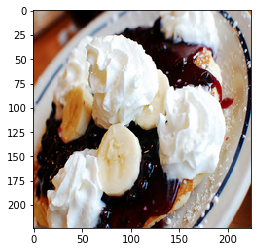

A plate that has food on top of it with powdered sugar.
A breakfast item on a plate is sitting on a table.
different kinds of food on a glass plate
a bowl with some pancakes and toppings on it
Pancakes on a plate with banana, sauce and whipped cream toppings


In [10]:
display_image_captions(500)

In [11]:
# Code to load the Densenet121 model trained on imagenet dataset  

def load_model(model_path):
    if os.path.exists(model_path):
        with open(model_path, mode='rb') as file:
            image_model = pickle.load(file)
    else:
        model = DenseNet121(include_top=True, weights='imagenet')
        x = (model.layers[-2].output)
        image_model = Model(inputs=model.input, outputs=x)
        with open(model_path, mode='wb') as file:
            pickle.dump(image_model, file)
    return image_model

In [12]:
# Code to get 1024 value tensor representation of images in the training dataset

def process_images(data_dir, filenames):
    model_path='image_model_Dense121.pkl'
    image_model=load_model(model_path)
    num_images = len(filenames)
    shape = (num_images, 1024)
    image_values = np.zeros(shape=shape, dtype=np.float32)
    i=0
    for image in filenames:
        path = os.path.join(data_dir, image)
        img=load_image(path)
        img=np.reshape(img,(1,224,224,3))
        image_values[i]=image_model.predict(img)
        i=i+1
        sys.stdout.write("\r- {} images processed out of {}".format(i,num_images))
        sys.stdout.flush()
       
    return image_values

In [13]:
# If the image tensor file already exists in memory then reload it,otherwise process all images and save their tensor-values
#to the file so it can be reloaded quickly.

def process_images_train():    
    image_tensor_path = os.path.join('./',"image_values_train_Dense121.pkl")    
    if os.path.exists(image_tensor_path):
        with open(image_tensor_path, mode='rb') as file:
            image_values = pickle.load(file)
    else:
        print('Image processing status:')
        image_values = process_images(train_image_path,filenames_train)
        with open(image_tensor_path, mode='wb') as file:
            pickle.dump(image_values, file)
    return image_values

## Tokenizer

In [14]:
image_values_train = process_images_train()

In [15]:
mark_start = 'starttoken '
mark_end = ' endtoken'

In [16]:
# Code to select the shortest caption from the list of 5 captions for each image

single_captions_train=[]
for caption_list in captions_train:
    min_length=len(caption_list[0])
    for caption in caption_list:
        caption_length=len(caption)
        if(caption_length<=min_length):
            capt=caption
            min_length=caption_length
    single_captions_train.append(capt.lower().translate(str.maketrans('', '', string.punctuation)))

In [17]:
single_captions_train[0]

'a man riding on the back of a motorcycle'

In [18]:
# Code to add start marker and end marker for every caption. 

captions_train_marked = [mark_start + caption + mark_end for caption in single_captions_train]
captions_train_marked[0]

'starttoken a man riding on the back of a motorcycle endtoken'

In [19]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(captions_train_marked)

In [20]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [21]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [22]:
len(tokenizer.word_index)

11195

In [23]:
tokens_train = tokenizer.texts_to_sequences(captions_train_marked)
tokens_train[0]

[2, 1, 11, 43, 4, 7, 204, 5, 1, 124, 3]

In [24]:
word_index = tokenizer.word_index

In [25]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Word2vec

In [26]:
sentences = [[word for word in sentence.lower().split()] for sentence in captions_train_marked]

In [27]:
embedding_size=1024

In [28]:
def load_word2vec_model(path):
    if os.path.exists(path):
        word_model=KeyedVectors.load(path, mmap='r')
    else:
        word_model = Word2Vec(sentences, min_count=1, size = embedding_size, iter = 1000)
        word_model.wv.save("word2vec.model")
    
    return word_model

In [29]:
word_model = load_word2vec_model("word2vec.model")

In [30]:
word_model.most_similar('person')

[('man', 0.787986159324646),
 ('guy', 0.6374941468238831),
 ('woman', 0.6269971132278442),
 ('boy', 0.5984575748443604),
 ('kid', 0.5538904070854187),
 ('girl', 0.5408806800842285),
 ('lady', 0.5281223058700562),
 ('someone', 0.5254602432250977),
 ('child', 0.5006622076034546),
 ('player', 0.41493216156959534)]

In [31]:
pretrained_weights = word_model.wv.syn0

In [32]:
vocab_size, emdedding_size = pretrained_weights.shape

In [33]:
vocab_size

11195

# Data Generator

In [34]:
def train_data_generator(batch_size):
    while True:
        if 'count' not in locals():
            count=0
        if(count+batch_size<len(filenames_train)):
            samples = np.arange(count,count+batch_size)
            count=count+batch_size
        else:
            samples=np.arange(count,len(filenames_train))
            count=0

        image_values = image_values_train[samples]

        tokens_list = []
        
        for i in samples:
            tokens = tokens_train[i]
            tokens_list.append(tokens)

        num_tokens = [len(t) for t in tokens_list]
        
        max_tokens = np.max(num_tokens)

        tokens_padded = pad_sequences(tokens_list,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post',dtype='int32')       
              
        input_data = np.stack(tokens_padded[:, 0:-1])
        output_data = np.expand_dims(tokens_padded[:, 1:],-1)
        
        yield ([input_data,image_values],output_data)        

# Model Building

In [35]:
batch_size = 32

In [36]:
generator_train = train_data_generator(batch_size=batch_size)

In [37]:
word_embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
for word, i in word_index.items():
    word_embedding_vector = word_model.wv.wv[word]
    if word_embedding_vector is not None:
        word_embedding_matrix[i] = word_embedding_vector

In [38]:
lang_input = Input(shape=(None, ))
lang_model = Embedding(len(word_index) + 1,embedding_size,weights=[word_embedding_matrix],input_length=None,trainable=False)(lang_input)

image_model = Input(shape=(1024,))

# The 1024 length image vector is multiplied element-wise with the word embedding vector

multiplied = Multiply()([lang_model, image_model])

lstm1 = LSTM(1200, name='LSTM1',return_sequences=True)(multiplied)
lstm2 = LSTM(1200, name='LSTM2',return_sequences=True)(lstm1)

# Output layer that has the vocabulary length as the number of nodes

output= TimeDistributed(Dense(len(word_index)+1,activation='softmax'))(lstm2)

model = Model(inputs=[lang_input, image_model],
                      outputs=[output])

In [39]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy')

In [40]:
%%time
model.fit_generator(generator=generator_train,
                            steps_per_epoch=int(num_images_train / batch_size) + 1,
                            epochs=10)

Epoch 1/10
3697/3697 [==============================] - 2051s 555ms/step - loss: 2.3109
Epoch 2/10
3697/3697 [==============================] - 2044s 553ms/step - loss: 2.0001
Epoch 3/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.8736
Epoch 4/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.7668
Epoch 5/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.6787
Epoch 6/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.5951
Epoch 7/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.5251
Epoch 8/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.4785
Epoch 9/10
3697/3697 [==============================] - 2045s 553ms/step - loss: 1.4368
Epoch 10/10
3697/3697 [==============================] - 2043s 553ms/step - loss: 1.4136
Wall time: 5h 40min 42s


# Generate Captions

In [41]:
model_path='image_model_Dense121.pkl'
image_model=load_model(model_path)

In [42]:
img_size = backend.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [43]:
image_values_size = backend.int_shape(image_model.output)[1]
image_values_size

1024

In [44]:
def predict_caption(image_path, max_tokens=20):

    image = load_image(image_path)

    image_batch = np.expand_dims(image, axis=0)

    image_values = image_model.predict(image_batch)

    input_data = np.zeros(shape=(1, max_tokens), dtype=np.int)

    token_int = token_start

    output_text = ''

    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:

        input_data[0, count_tokens] = token_int

        output = model.predict([input_data,image_values])

        token_onehot = output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)
        
        if(token_int==0):
            output_text='Cannot generate caption'
            break

        predicted_word = tokenizer.index_word[token_int]      
        
        if (token_int!=token_end):           
            if (count_tokens==0):
                output_text += " " + predicted_word.capitalize()
                count_tokens += 1
            
            else:
                output_text += " " + predicted_word
                count_tokens += 1
        
        else:
            output_text += '.'
            count_tokens += 1            

    plt.imshow(image)
    plt.show()

    print("Predicted caption:")
    print(output_text)

# Sample Captions

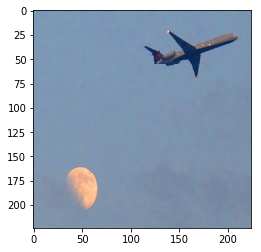

Predicted caption:
 A plane is flying in the clear sky.


In [71]:
predict_caption("images/val2017/val2017/000000022396.jpg")

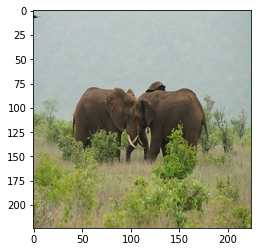

Predicted caption:
 An elephant with tusks stands in some bushes.


In [72]:
predict_caption("images/val2017/val2017/000000024919.jpg")

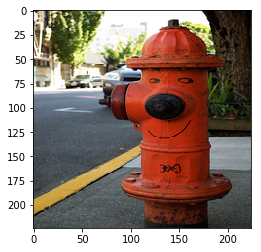

Predicted caption:
 A fire hydrant on a sidewalk near a street.


In [73]:
predict_caption("images/val2017/val2017/000000026926.jpg")

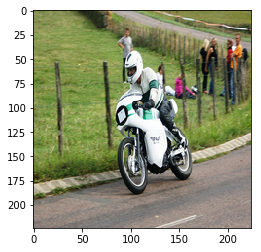

Predicted caption:
 A man is riding a motorcycle down a street.


In [74]:
predict_caption("images/val2017/val2017/000000007816.jpg")

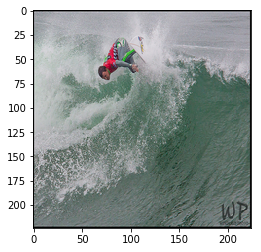

Predicted caption:
 A man on a surfboard riding a wave.


In [75]:
predict_caption("images/val2017/val2017/000000007278.jpg")

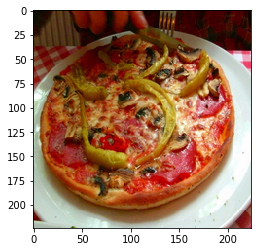

Predicted caption:
 A pizza on a plate on a table.


In [76]:
predict_caption("images/val2017/val2017/000000027696.jpg")

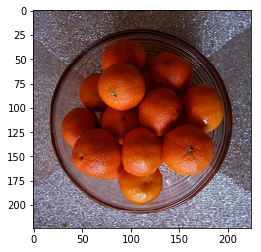

Predicted caption:
 A bowl filled with lots of oranges on a table.


In [77]:
predict_caption("images/val2017/val2017/000000050896.jpg")

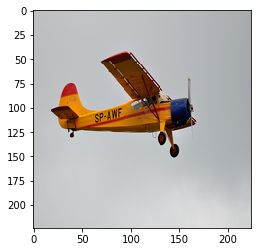

Predicted caption:
 A small plane flying in a cloudy sky.


In [79]:
predict_caption("images/val2017/val2017/000000052017.jpg")

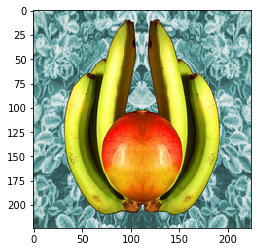

Predicted caption:
 A bowl of bananas sitting on a table.


In [70]:
predict_caption("images/val2017/val2017/000000006012.jpg")

In [68]:
model.save_weights("Image_captioning_model.h5")

# References

https://github.com/Hvass-Labs/TensorFlow-Tutorials

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.